# Syrtis Demonstration - Subterranean Heat Flows
# Heat Losses from Buried Habitats and Habitats inside Caves

Many modern proposals for near-future Mars and lunar habitation rely on habitats and crewed volumes located underground or beneath thick layers of regolith for radiation protection. This has substantial benefits for reducing launched mass while reducing crew health effects, as shielding of a few metres of locally-acquired regolith can reduce radiation levels in the habitat to safe levels without requiring many tonnes of water or metal to be launched as part of the habitat assembly. However the low thermal conductivity of regoliths, and the large thicknesses required, make this a challenging thermal design scenario. Syrtis allows for the analysis of habitats under layers of regolith, buried entirely below the surface and inside large lava tubes.

In [1]:
from syrtis import *
from syrtis.configuration import Configuration
from syrtis.solver import Solver
from syrtis.material import Solid, ConstrainedIdealGas
from syrtis.habitat import Habitat
import numpy as np
import matplotlib.pyplot as plt

### Setup and Configuration
The syrtis modules are imported. The two solid materials used for the habitat (aluminium and a generic plastic). Two gases are needed: the internal habitat air at 101kPa, and the higher pressure air which fills inflatable spaces inside the habitat walls.

The values of regolith thermal conductivity, and thermal conductivity of the sintered regolith, are hard to come by and appear somewhat variable. There appears to be no existing high-quality data on the thermal properties of sintered Martian regolith whatsoever, so values for [laser-sintered lunar regolith simulant](https://core.ac.uk/download/pdf/227532695.pdf) are used instead. Similarly, measured values of unmodified soil conductivity vary from just [0.039W/m/K in the top 30cm of soil at the InSight landing site](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2021JE006861) to [0.085W/m/K from the northerly Phoenix site](https://www.lpi.usra.edu/meetings/lpsc2009/pdf/1125.pdf). This compares to laboratory values of [2.94W/m/K for the solid particle](https://art.torvergata.it/retrieve/handle/2108/51616/132578/04%20PSS.pdf). Considering this, the values below have been selected.

For the sintered regolith: $\lambda = 1.0 W/m\cdot K$, $rho = 2300 kg/m^3$

For the unsintered regolith near the surface: $\lambda = 0.15 W/m\cdot K$, $\rho = 1100 kg/m^3$

For the virgin rock around the lava tube: $\lambda = 2.0 W/m\cdot K$, $\rho = 3000 kg/m^3$.

Data on thermal and wind conditions in lava tubes is still an open question, but [simulation suggests](https://www.sciencedirect.com/science/article/pii/S0019103510001491?via=ihub) that temperatures of both air and ground would be stable near the coldest air temperature on the surface, and that wind inside would close to zero.

In [2]:
# Materials definitions
plastic = Solid("Generic plastic", 10, 1300, 1420, absorb=0.89, emit=0.84)
open_cell_foam = Solid("Generic open-cell polyurethane foam", 0.036, 10, 1500, absorb=0.89, emit=0.84)

internal_air = ConstrainedIdealGas("STP Air", 101325, 29, 0.71, 17.9e-6, 1010, 0.0252)
inflation_air = ConstrainedIdealGas("Air at 2bar", 202630, 29, 0.71, 17.9e-6, 1010, 0.0252)

sintered_regolith = Solid("Laser sintered lunar regolith", 1.0, 2300, 2000, 0.29)

mount_sharp_summer = Configuration("Curiosity landing area, Mount Sharp, at noon in summer",
 "constant temperature", 290, 0.15, 0.29, 250, 610, 5, "axial", 70, 90, 610, T_habitat=293)
mount_sharp_winter = Configuration("Curiosity landing area, Mount Sharp, at night in winter",
 "constant temperature", 165, 0.15, 0.29, 110, 610, 5, "axial", 0, 90, 0, T_habitat=293)

mount_sharp_lava_tube_summer = Configuration("Lava tube in summer",
 "constant temperature", 200, 2.0, 0.29, 200, 610, 0.02, "axial", 0, 0, 0, T_habitat=293)
mount_sharp_lava_tube_winter = Configuration("Lava tube in winter",
 "constant temperature", 165, 2.0, 0.29, 165, 610, 0.02, "axial", 0, 0, 0, T_habitat=293)

## Habitat Geometry

Construction below the surface in many cases neccessitates inflatable habitats, as large solid modules cannot be easily transported and lifted on the surface. In addition, the relative lightweight nature of inflatable habitats makes them a better candidate for moving into trenches and caves. Little reliable data on the wall assemblies of inflatable habitats exist, so the following wall stackup has been used, based on TransHab designs

0.5mm of plastic (ETFE, a pressure bladder)

2mm of air at 2 bar, as a structural reinforcement section

0.5mm of plastic, a second pressure bladder

2mm of foam (approximating the Kevlar felt layer used to separate bladder layers on Transhab)

2mm of plastic (Kevlar, the structural layer)

10mm of foam (a low-density material used to buffer the pressure vessel from the rough surface of the regolith)

In [3]:
HAB_baseline = Habitat(orientation="horizontal", length=8, endcap_type="hemisphere")

HAB_baseline.create_static_shell(internal_air, 1.50)

HAB_baseline.create_static_shell(plastic, 0.5e-3)
HAB_baseline.create_static_shell(inflation_air, 2e-3)
HAB_baseline.create_static_shell(plastic, 0.5e-3)

HAB_baseline.create_static_shell(open_cell_foam, 2e-3)
HAB_baseline.create_static_shell(plastic, 2e-3)
HAB_baseline.create_static_shell(open_cell_foam, 10e-3)

HAB_sintered_shield = copy.deepcopy(HAB_baseline)
HAB_sintered_shield.create_static_shell(sintered_regolith, 1.5)
HAB_sintered_shield.create_ground_level(habitat_axis_height=1.4)

HAB_tunnel = copy.deepcopy(HAB_baseline)
HAB_tunnel.create_ground_level(habitat_axis_height=-3)

HAB_lava_tube = copy.deepcopy(HAB_baseline)
HAB_lava_tube.create_earthworks(25, 40, 1.75)

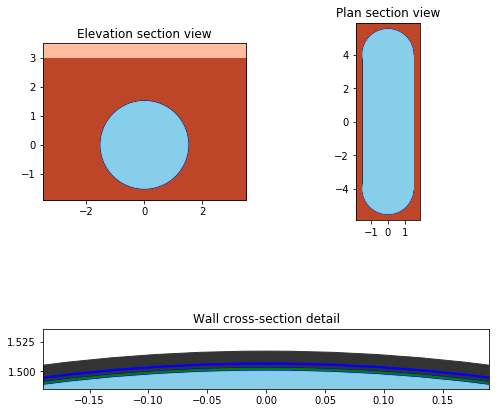

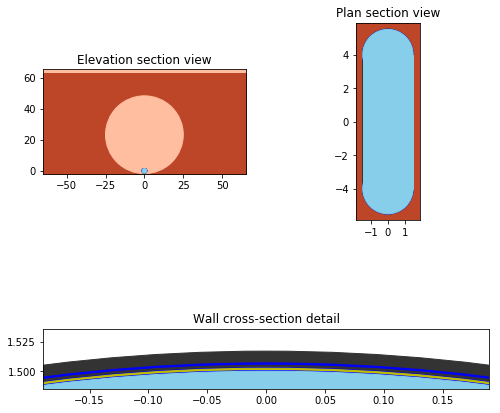

In [4]:
HAB_tunnel.draw(size=(8,8))
HAB_lava_tube.draw(size=(8, 8))

# Execution

In [5]:
HAB_baseline.verify_geometry()

baseline_summer = Solver("Baseline habitat, hot case", HAB_baseline, mount_sharp_summer)
baseline_summer.solve()

baseline_winter = Solver("Baseline habitat, cold case", HAB_baseline, mount_sharp_winter)
baseline_winter.solve()

In [6]:
HAB_sintered_shield.verify_geometry()

sintered_shield_summer = Solver("Habitat with sintered shield, hot case", HAB_sintered_shield, mount_sharp_summer)
sintered_shield_summer.solve()

sintered_shield_winter = Solver("Habitat with sintered shield, cold case", HAB_sintered_shield, mount_sharp_winter)
sintered_shield_winter.solve()

In [7]:
HAB_tunnel.verify_geometry()

tunnel_summer = Solver("Habitat in tunnel, hot case", HAB_tunnel, mount_sharp_summer)
tunnel_summer.solve()

tunnel_winter = Solver("Habitat in tunnel, cold case", HAB_tunnel, mount_sharp_winter)
tunnel_winter.solve()

In [8]:
HAB_lava_tube.verify_geometry()

lava_tube_summer = Solver("Habitat in lava tube, hot case", HAB_lava_tube, mount_sharp_lava_tube_summer)
lava_tube_summer.solve()

lava_tube_winter = Solver("Habitat in lava tube, cold case", HAB_lava_tube, mount_sharp_lava_tube_winter)

lava_tube_winter.solve()

In [9]:
baseline_heat_avg = (baseline_summer.heat + baseline_winter.heat) / 2
baseline_heat_variation = (baseline_summer.heat - baseline_winter.heat) / 2
 
sintered_shield_heat_avg = (sintered_shield_summer.heat + sintered_shield_winter.heat) / 2
sintered_shield_heat_variation = (sintered_shield_summer.heat - sintered_shield_winter.heat) / 2

tunnel_heat_avg = (tunnel_summer.heat + tunnel_winter.heat) / 2
tunnel_heat_variation = (tunnel_summer.heat - tunnel_winter.heat) / 2

lava_tube_heat_avg = (lava_tube_summer.heat + lava_tube_winter.heat) / 2
lava_tube_heat_variation = (lava_tube_summer.heat - lava_tube_winter.heat) / 2

# Results
We can now easily compare the cases for different forms of subterranean habitat, against a habitat with identical geometry sitting on the surface. As we might expect, both the sintered regolith shield and tunnel cases show substantially lower heat loss than the surface due to the effective insulation provided by the regolith. The tunnel shows the lowest heat loss of all, with loss on summer days falling to almost zero as the surface of the regolith heats up to match the temperatures inside the habitat.

The lava tube experiences slightly higher loss than the surface habitat on average, but is almost entirely insulated from the variability of the surface because of the near-constant cold temperatures inside the tube.

Text(0, 0.5, 'Heat loss (W)')

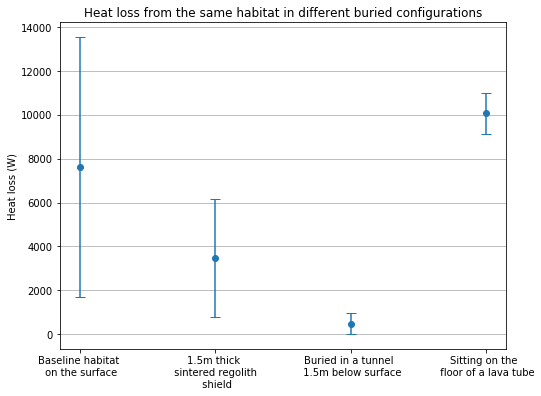

In [10]:
plt.figure(figsize=(8,6))

plt.errorbar(["Baseline habitat \n on the surface", "1.5m thick \n sintered regolith \n shield", 
"Buried in a tunnel \n 1.5m below surface", "Sitting on the \n floor of a lava tube"], 
    [baseline_heat_avg, sintered_shield_heat_avg, tunnel_heat_avg, lava_tube_heat_avg], 
    yerr=[baseline_heat_variation, sintered_shield_heat_variation, tunnel_heat_variation, lava_tube_heat_variation], 
    fmt="o", capsize=5)


plt.grid(True, "major", "y")
plt.title("Heat loss from the same habitat in different buried configurations")
plt.ylabel("Heat loss (W)")

The breakdown looks almost exactly as expected. The surface habitat experiences higher solar gain due to the white outer surface, but also higher losses due to the higher surface temperature. Adding the sintered shield reduces radiative losses substantially by lowering the outer wall temperature. The tunnel experiences no heat flux apart from conduction (which is extremely small due to the insulating properties of the soil). The lava tube clearly experiences no insolation,but also no radiative loss to the sky. The vast majority of flux is from radiative exchange with the ground.

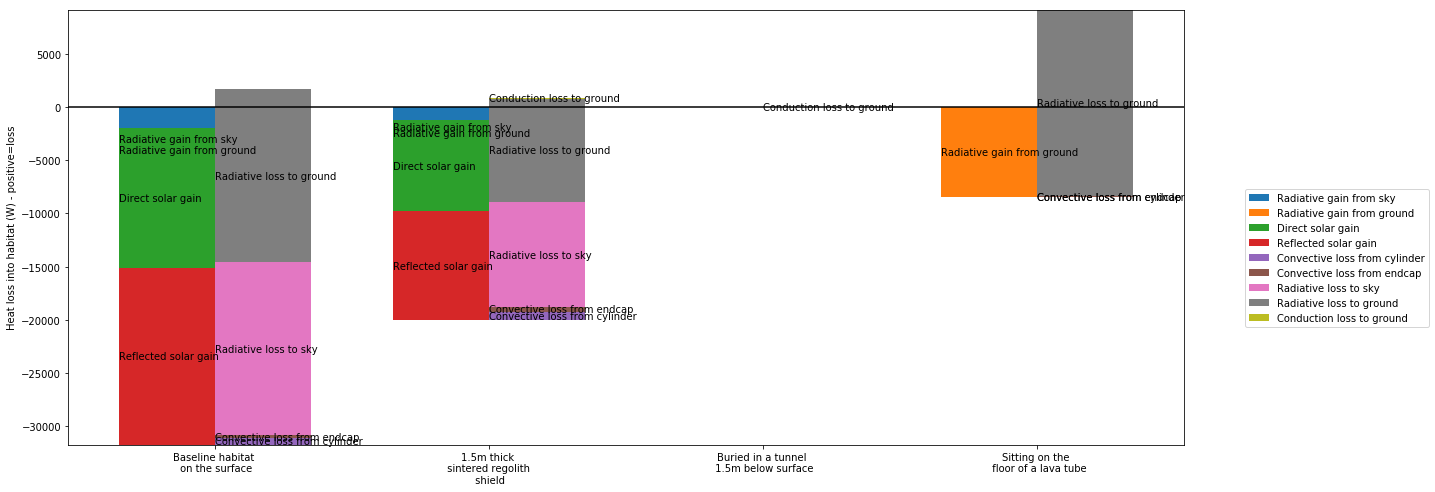

In [11]:
plt.figure(figsize=(20,8))
tools.plot_power_balance([baseline_summer.report, sintered_shield_summer.report, tunnel_summer.report, lava_tube_summer.report], 
    labels=["Baseline habitat \n on the surface", "1.5m thick \n sintered regolith \n shield", 
"Buried in a tunnel \n 1.5m below surface", "Sitting on the \n floor of a lava tube"])